# Fundamentals of Computer Graphics, Image Processing, and Vision 
## Exercise 2: Epipolar Geometry

In this exercise you will explore estimating the relationship between two camera views using the epipolar geometry concepts learned in the lectures.


**NOTE:** When submitting the Colab notebook, please remove any unnecessary/debug cells. That is, your notebook should be clean to make it easy for the grader to follow. 

---

**Student 1:**  
Name:  Rony Kositsky
ID:  205817893

**Student 2:**  
Name: Yonatan Gartenberg
ID:  311126205

---

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# utility function for reading the 2d points from the given txt files
def load_file(name):
    lst = []
    f = open(name, 'r')
    for line in f:
        lst.append(line.strip().split())
    f.close()
    return np.array(lst, dtype=np.float32)

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Part 1: Fundamental Matrix Estimation

Recall that we are interested in solving the **correspondence problem**. Specifically, given two images taken from cameras at different positions. How do we match a point in the first image to a point in the second image?

We have seen that it is possible to learn a mapping of points in one image to *lines* in another image using the Fundamental Matrix. 

To do so, we have provided you with two scenes. 
- In the first scene, `sceneA`, we have provided you with corresponding point locations listed in `sceneA-pts2d-1.txt ` and `sceneA-pts2d-2.txt`. 
- In the second scene, `sceneB`, we ask you to compute the corresponding points yourself. Please use the provided utility script `tag_image.py` to do so. 

---

**Hint**: When solving for the fundamental matrix $F$, think about how many correpsonding points we need. What happens if we have more pairs than required?

### Question 1 
Write a function that computes the Fundamental Matrix $F$ that satisfies the epipolar constraints defined by the sets of corresponding points using **least squares**.

In [7]:
def calculate_fundamental_matrix(points_a, points_b, number_of_rows):
  A = np.empty((num_rows, 9))
  for i in range(num_rows):
    A[i] = np.kron(np.append(points_b[i],1), np.append(points_a[i],1))
  (U, S, V) = np.linalg.svd(A)
  V = V.conj().T;
  return V[:,8].reshape(3,3).copy()

In [8]:
# Compute the Fundamental Matrix for Scene A
pts_a_a = load_file('/content/drive/My Drive/Colab Notebooks/input/sceneA/sceneA-pts2d-1.txt')
pts_b_a = load_file('/content/drive/My Drive/Colab Notebooks/input/sceneA/sceneA-pts2d-2.txt')


num_rows, num_cols = pts_a_a.shape
F_sceneA = calculate_fundamental_matrix(pts_a_a, pts_b_a, num_rows)
print(f'Scene A: Fundametal Matrix with Rank = 3: \n {F_sceneA} \n')

Scene A: Fundametal Matrix with Rank = 3: 
 [[ 2.67672836e-07 -2.57710176e-06  1.12880871e-03]
 [ 7.43804123e-06  3.90140797e-06  7.31416301e-03]
 [-2.43337305e-03 -1.14507273e-02  9.99904090e-01]] 





---

Recall that $F$ is only known up to a scale factor. To make sure that your code is correct, if you solved for $F$ correctly, you should get a matrix that is a scaled equivalent to the following for `sceneA`:

     F =  [[ 2.67713722e-07 -2.57763422e-06  1.12898577e-03]
           [ 7.43898031e-06  3.90196194e-06  7.31449001e-03]
           [-2.43366396e-03 -1.14515247e-02  1.00000000e+00]] 



In [9]:
pts_a_b = load_file('/content/drive/My Drive/Colab Notebooks/input/sceneB/our_pts1.txt')
pts_b_b = load_file('/content/drive/My Drive/Colab Notebooks/input/sceneB/our_pts2.txt')

num_rows, num_cols = pts_a_b.shape
F_sceneB = calculate_fundamental_matrix(pts_a_b, pts_b_b, num_rows)
print(f'Scene B: Fundametal Matrix with Rank = 3: \n {F_sceneB} \n')

Scene B: Fundametal Matrix with Rank = 3: 
 [[-7.19142614e-07  5.80962970e-06  2.04050954e-03]
 [-1.21755765e-06  3.25431074e-05  4.31727310e-02]
 [-2.69947837e-03 -5.70805205e-02  9.97429936e-01]] 





**Question:** Notice that the least squares estimate of $F$ is of full rank. However, the Fundamental Matrix should be a matrix of rank $2$. Why is the fundamental matrix of rank $2$? (We require you to show only the upper bound. That is, that $F$ is not of full rank).

**Answer:** We calculated F from the equation $x_r^TFx_l = 0$. We can conclude that the right epipolar line lies on the surface of $Fx_l$, and therefore, it holds that $e_r^TFx_l = 0$. From simetry we can prove the same equation for the left epipolar line $e_l$. We can deduce that F has a non-zero eigenvector corresponding with a zero eigenvalue.Therefore, F's rank <= F's dimesion -1. We used F with a dimension=3, so the upper bound for the rank is 2.


---

### Question 2
From the proof you provided above, $F$ should be of rank 2. 
Therefore, we must reduce the rank of the estimated $F$. 
To do so, we can decompose $F$ using singular value decomposition (SVD) into the matrices $U\Sigma V^T = F$. We can then estimate a rank 2 matrix by setting the smallest singular value in $\Sigma$ to zero thus generating $\Sigma'$. The Fundamental Matrix is then easily calculated as $F=U\Sigma 'V^T$.

Compute the fundamental matrix $F$ of rank 2 using SVD as described above.

In [10]:
def reshape_to_rank_two(A):
  U,S,V = np.linalg.svd(A)
  min_value = np.argmin(S)
  S[min_value] = 0
  return np.dot(U*S,V)

F_sceneA_rank_2 = reshape_to_rank_two(F_sceneA)
print(f'Scene A: Fundametal Matrix with Rank = 2: \n {F_sceneA_rank_2} \n')

Scene A: Fundametal Matrix with Rank = 2: 
 [[ 2.35760827e-07 -2.56791282e-06  1.12880874e-03]
 [ 7.44181232e-06  3.90032210e-06  7.31416300e-03]
 [-2.43337304e-03 -1.14507273e-02  9.99904090e-01]] 



In [11]:
F_sceneB_rank_2 = reshape_to_rank_two(F_sceneB)
print(f'Scene A: Fundametal Matrix with Rank = 2: \n {F_sceneB_rank_2} \n')

Scene A: Fundametal Matrix with Rank = 2: 
 [[ 1.35883073e-07  5.77014934e-06  2.04050960e-03]
 [-1.25941496e-06  3.25450401e-05  4.31727310e-02]
 [-2.69947831e-03 -5.70805205e-02  9.97429936e-01]] 




---

### Question 3
Given our fundamental matrix $F$ of rank 2, we can now compute the epipolar line $\ell_b$ in image $B$ corresponding to a point $p_a$ in image $A$: 
    $\ell_b = Fp_a$

A similar equation can be used for computing the epipolar lines in image $A$.

You are now tasked with drawing these epipolar lines. 

Observe that drawing the epipolar lines on the image plane is not trivial. This is because the lines $\ell_i$ are defined in homogeneous coordinates whereas the standard line function takes two input points.

In order to find two such points, we can find the intersection of a given line $\ell_i$ with the image boundaries. 

To do so, we need to compute two things: 
- The line $\ell_L$ corresponding to the left-hand side of the image.
- The line $\ell_R$ corresponding to the right-hand side of the image. 

Once, we have these lines, we can compute the intersection point $P_{i,L}$ between $\ell_i$ and $\ell_L$ and intersection point $P_{i,R}$ between $\ell_i$ and $\ell_R$.

Once we have these two points, we can compute the line running through the points $P_{i,L}$ and $P_{i,R}$. 

---

To summarize, in this question you are required to compute the following: 
1. The lines corresponding to the left-hand and right-hand boundaries of the image. 
2. The intersection point between the image boundaries and the given epipolar line.

After computing these lines, you should draw the estimated epipolar lines on each of the two images. For each scene, please display the two images side-by-side with the epipolar lines drawn on each.

---

**Hint**: The intersection between two lines $l_1$ and $l_2$ is a point $p$ in homogeneus coordinates s.t. $p\cdot l_1=0$ and $p\cdot l_2=0$, that is a point $p$ which is perpendicular to both $l_1$ and $l_2$. 


In [12]:
def draw_lines(points, F, width, image):
  for point in points:
    point = np.append(point, 1)
    dot = np.dot(F, point)
    a,b,c = dot[0], dot[1], dot[2]
    left = int(-c/b)
    right = int(-(a*width+c)/b)
    left_point, right_point = (0, left), (width, right)
    cv2.line(image, left_point, right_point, (0,100,0), 2)

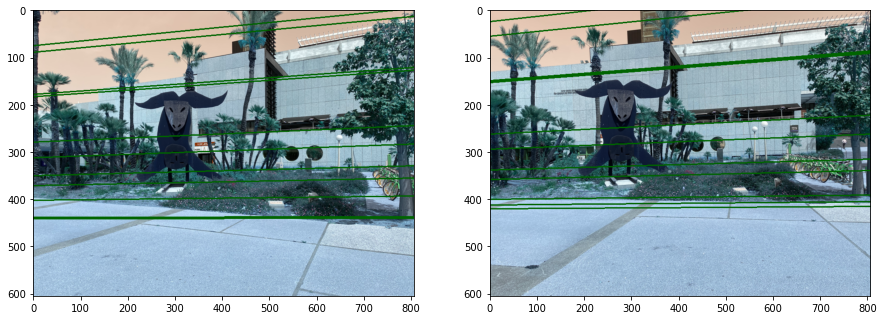

In [16]:
# Draw the epipolar lines on the images of Scene A and display + save the images side-by-side
image_one = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/sceneA/sceneA-im-1.png')
image_two = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/sceneA/sceneA-im-2.png')
image_one_height, image_one_width, null  = image_one.shape
image_two_height, image_two_width, null  = image_two.shape
   
draw_lines(pts_a_a, F_sceneA_rank_2, image_one_width, image_one)
draw_lines(pts_b_a, F_sceneA_rank_2, image_two_width, image_two)

fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(image_one)
ax[1].imshow(image_two)
plt.show()

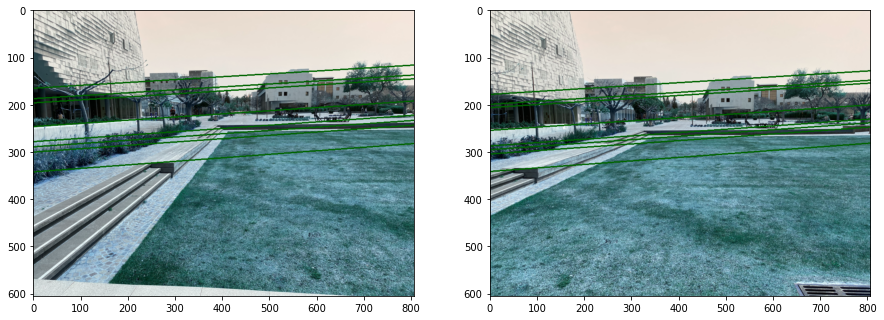

In [17]:
# Draw the epipolar lines on the images of Scene B and display + save the images side-by-side
image_one = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/sceneB/sceneB-im-1.png')
image_two = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/sceneB/sceneB-im-2.png')
image_one_height, image_one_width, null  = image_one.shape
image_two_height, image_two_width, null  = image_two.shape

draw_lines(pts_a_b, F_sceneB_rank_2, image_one_width, image_one)
draw_lines(pts_b_b, F_sceneB_rank_2, image_two_width, image_two)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(image_one)
ax[1].imshow(image_two)
plt.show()

---

### *Question 4: BONUS (5-10pts)*

Take a look at the results of the last section. You may notice that the epipolar lines are not exact.

The problem here is that the offset and scale of the points is large and biased compared to some of the constants. To fix this, we can normalize the points.

Specifically, we want to construct a transformation $T$ that will make the mean of the points $0$ and scale the points to magnitude $1$. 
In other words, we wish to find:
$$
\begin{equation*}
\begin{pmatrix}
{u'} \\
{v'} \\
{1}  \\
\end{pmatrix}
=
\begin{pmatrix}
{s} & {0} & {0} \\
{0} & {s} & {0} \\
{0} & {0} & {1} \\
\end{pmatrix}
\begin{pmatrix}
{1} & {0} & {-c_u} \\
{0} & {1} & {-c_v} \\
{0} & {0} & {1} \\
\end{pmatrix}
\begin{pmatrix}
{u} \\
{v} \\
{1} \\
\end{pmatrix}
\end{equation*}
$$

The transform matrix $T$ is the product of the scale and offset matrices. 
Notice that $c_u, c_v$  are simply the mean of the points.
To compute the scale $s$ you can  first estimate the standard deviation after subtracting the means of the points. Then, $s$ can be defined as the reciprocal of the standard deviation.


---

Create two matrices $T_a$ and $T_b$ for the set of points defined in the files `sceneB-pts2d-1.txt` and `sceneB-pts2d-2.txt`, respectively. 

Then, normalize the two sets of points to compute the new normalized fundamental matrix $\hat F$. 

Note: make sure that $\hat F$ is of rank $2$!

(You only need to complete this for `sceneB` using the points provided to you)

In [ ]:
# Complete the bonus. Compute the normalized Fundamental Matrix using the points given in `sceneB-pts2d-1.txt` and `sceneB-pts2d-2.txt` for `sceneB`. 
# Then visualize the epipolar lines obtained with the matrix you got.
####################
## YOUR CODE HERE 
####################

## Part 2: Finding the Correspondences

Up to now, we've only discussed how one can compute the epipolar lines between two images.  
In this section, we use a window-based approach for  estimating **dense stereo correspondence**. 

For this part, we will be working with the images named `corr-img-l.png` and `corr-img-r.png` found in `input/correspondences`.

Here, you will implement the stereo alogrithm and take a window around every pixel in one image and search for the best match in the other image. This concept is discussed in the class lecture (~slides 58-68).

The basic algorithm is defined as follows: 

1. For each epipolar line / horizontal scan line:  
  a. For each pixel $p$ on the left line:  
    1. Compare a window around $p$ with same window shifted along the same horizontal scan line in the other image.  
    2. Pick location corresponding to the best matching window.

To help simplify the problem, we will assume that the two images are aligned horizontally. Therefore, when performing the matching, you only need to scan across the same horizontal scan line of the other image.

When computing the similarities, we will use the sum of squared differences (SSD) measure. 


---

### Question 1: Implementing SSD for Computing Disparity Map

Implement the SSD matching algorithm. The algorithm returns a **disparity** image $D$ where 
\begin{equation}
  L(y,x) = R(y,x+D(y,x))
\end{equation}
when matching from the left image to the right image, denoted by $L$ and $R$, respectively.

Then, repeat this for matching from the right image to the left image. That is, you should output two images: 
1. $D_L = disparity(L,R)$
2. $D_R = disparity(R,L)$

Then, change the values of: 
1. The window size
2. The disparity range (i.e., the maximum number of pixels to slide the window over)

How does changing these values affect the results?
Please clearly display and label the results in the notebook with the two disparity maps shown side-by-side.

**Some notes to consider**: 
* When computing the SSD between the two window patches, you may use `cv2.matchTemplate` and `cv2.TM_SQDIFF_NORMED`.
* We provide you the ground truth images to allow you to compare your results. Don't worry if you don't get something similar to the ground truths.
* If you see that the execution time takes a long time, you may want to consider down-sampling the input images. Hint: use `cv2.pyrDown()`.

When displaying the images, please display them in grayscale! 

**Hint**: To verify that your implementation is correct, think about the values you should obtain closer to the camera. Larger values should be shown in white with lower values shown in black.

In [19]:
L = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/correspondences/corr-img-l.png', cv2.IMREAD_GRAYSCALE) 
R = cv2.imread('/content/drive/My Drive/Colab Notebooks/input/correspondences/corr-img-r.png', cv2.IMREAD_GRAYSCALE)
L_org = L * (1.0 / 255.0)
R_org = R * (1.0 / 255.0)

After computing the disparity maps, you should display the results side-by-side, which can be done using the follow cell as a reference. Please note that when displaying the results you should clearly specify the parameters used to obtain the results!

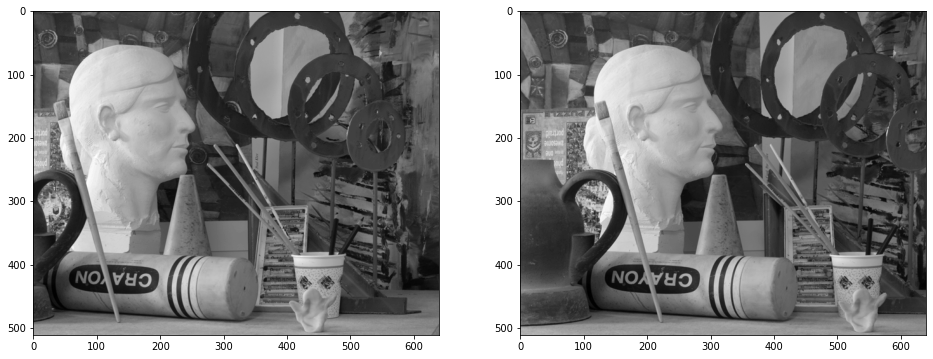

In [20]:
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(L, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(R, cmap='gray')

In [21]:
def findMin(a, b):
  if a < b: 
    return a
  else:
    return b

def findMax(a, b):
  if a < b: 
    return b
  else:
    return a

# Go over every pixel in the image, and for each pixel:
# Determain it's range boundries (avoid size overflow)
# take the sub image as the "picture" to compare
# compare with cv2.matchtemplate(cv2.cv2.TM_SQDIFF_NORMED)
# use cv2.minMaxLoc on the result to obtain the location of the best match found 
# the disparity is the distance between the original x position and the found x position
def stereo_match(left_img, right_img, window_size, disparity_range, compare_func = cv2.TM_SQDIFF_NORMED):
  #global min, max
  height, width = left_img.shape
  disparity_map = np.zeros((height, width))
  half_window_size = int(window_size/2)
  half_disparity_range = int(disparity_range/2)
  for x in range(height):
    row_top_border = findMin(x + half_window_size, height-1)
    row_bottom_border = findMax(x - half_window_size, 0)

    for y in range(width):
      #make sure to stay in picture's boundries
      col_top_border = findMin(y + half_window_size, width-1)
      col_bottom_border = findMax(y - half_window_size, 0)
      
      source_window = left_img[row_bottom_border:row_top_border, col_bottom_border:col_top_border]

      #column indices for disparity range (row stays the same)
      begin = findMax(y - half_disparity_range, 0)
      end = findMin(y + half_disparity_range, width-1)

      dest_window = right_img[row_bottom_border:row_top_border, begin:end]  #"cut" the destination window we'd like to examine
      match_result = cv2.matchTemplate(dest_window, source_window, compare_func)
      min_satum, max_satum, min_point, max_point = cv2.minMaxLoc(match_result)
      if compare_func == cv2.TM_CCORR_NORMED:
        point = max_point
      else:
        point = min_point
      x_offset = begin + point[0]

      result = abs(x_offset - y)
      disparity_map[x][y] = result

  return disparity_map

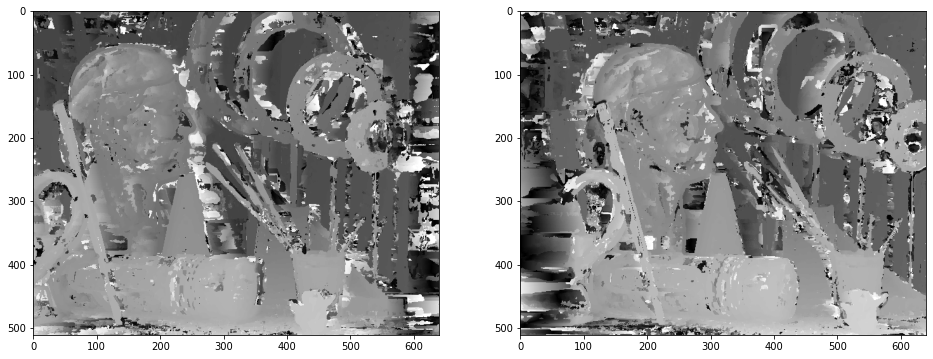

In [22]:
# Compute the disparity maps for multiple values of window size and maximum disparity
left = cv2.pyrDown(L)
right = cv2.pyrDown(R)
left_to_right = stereo_match(L, R, 6, 250)
right_to_left = stereo_match(R, L, 6, 250)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(left_to_right, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(right_to_left, cmap='gray')


**Question:** How does changing the value of the window size affect the results? How does changing the value of the maximum disparity range affect the results?  
**Answer:** After exploring a vast range of otions we've come to a conclusion that the window size and the disparity range are linked.

Separately, keeping the disparity range at 250, if we use very low values of the window size (around ~2), the result contains a lot of small noise, yet the details of the picture remain "sharp". If we use high values of the window size (around ~15), the result is less noisy, but the details appear to be blunt.

Regarding the disparity range, keeping the window size at 6 - If we use very low values (around ~120), there is also noise, and the smaller details of the pictures are distorted, where the bigger ones are more "in tact". If we use very high values (around ~300), the details are clearer, but the differences that suppose to be between close and far objects, are very small to distinct (i.e. the gray hues are very similar)

We conclude there is a "sweet spot" of the two. In oure case we achived it around window size = 6, and disparity range = 250


---

### Question 2: Analyzing the SSD Metric

Above we used SSD to compute the correspondences. However, SSD is **not** robust to small changes in the image.

Here, we will explore the sensitivity of SSD to small changes in the images.
Specifically, repeat Question 1, but with the following changes: 

1. Add Gaussian noise to one or both of the images. Visualize the resulting inputs to make sure the noise is visible. Then, run the matching algorithm with SSD again. 
2. Add contrast to one of the images and re-run the SSD matching algorithm. (changing the contrast means multiplying the pixel values by some constant factor)

Display the results of both of the variations. What happened to the results?

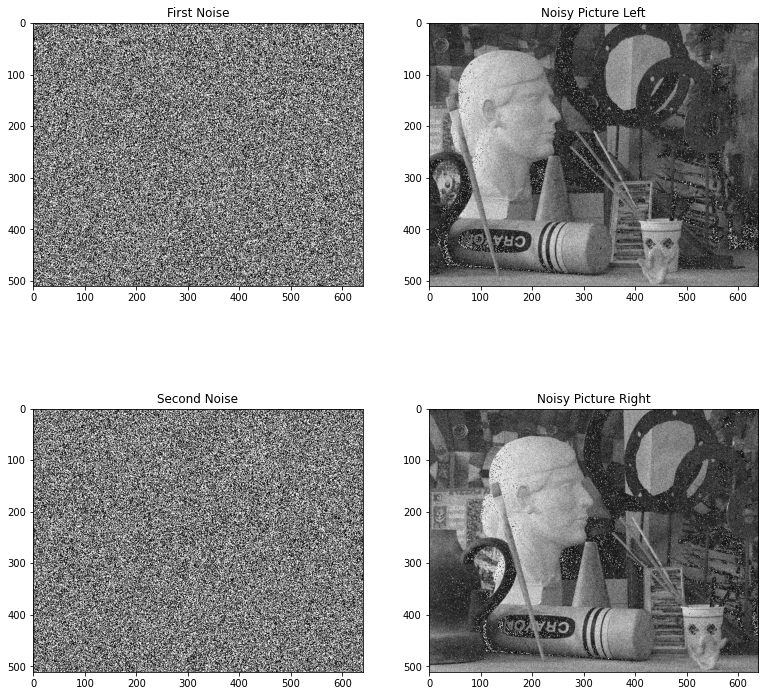

In [ ]:
# Demonstrate the sensitivity of the SSD matching algorithm as explained above

#Generating noise
noise1 = np.uint8(np.random.normal(0,20, L.shape))
noise_left = noise1 + L

noise2 = np.uint8(np.random.normal(0,20, R_org.shape))
noise_right = noise2 + R

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(noise1, cmap='gray')
ax[0, 1].imshow(noise_left, cmap='gray')
ax[1, 0].imshow(noise2, cmap='gray')
ax[1, 1].imshow(noise_right, cmap='gray')

ax[0, 0].set_title("First Noise")
ax[0, 1].set_title("Noisy Picture Left")
ax[1, 0].set_title("Second Noise")
ax[1, 1].set_title("Noisy Picture Right")

fig.set_figheight(13)
fig.set_figwidth(13)
plt.show()

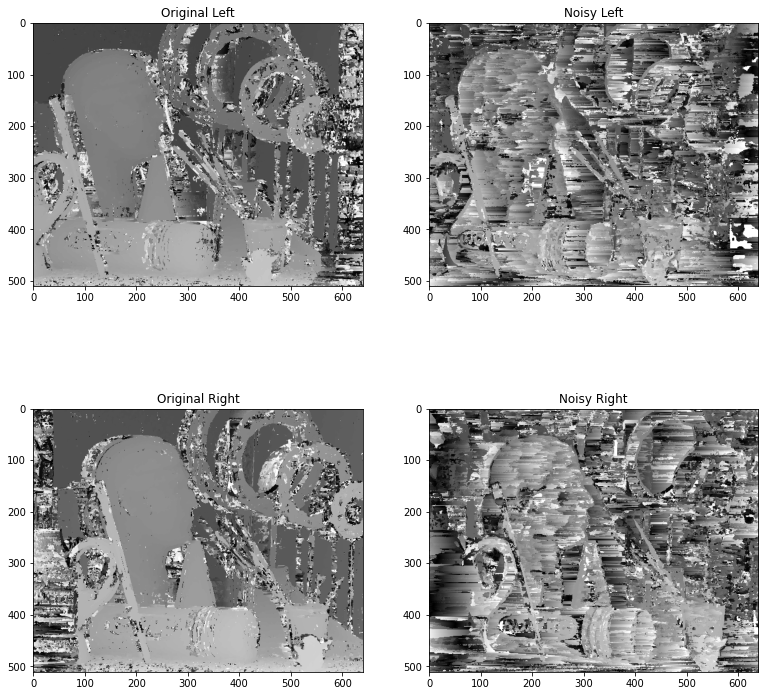

In [ ]:
left_to_right_noise = stereo_match(L, noise_right, 6, 250)
right_to_left_noise = stereo_match(R, noise_left, 6, 250)

#Comparing pictures
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(left_to_right, cmap='gray')
ax[0, 1].imshow(left_to_right_noise, cmap='gray')
ax[1, 0].imshow(right_to_left, cmap='gray')
ax[1, 1].imshow(right_to_left_noise, cmap='gray')

ax[0, 0].set_title("Original Left")
ax[0, 1].set_title("Noisy Left")
ax[1, 0].set_title("Original Right")
ax[1, 1].set_title("Noisy Right")

fig.set_figheight(13)
fig.set_figwidth(13)
plt.show()

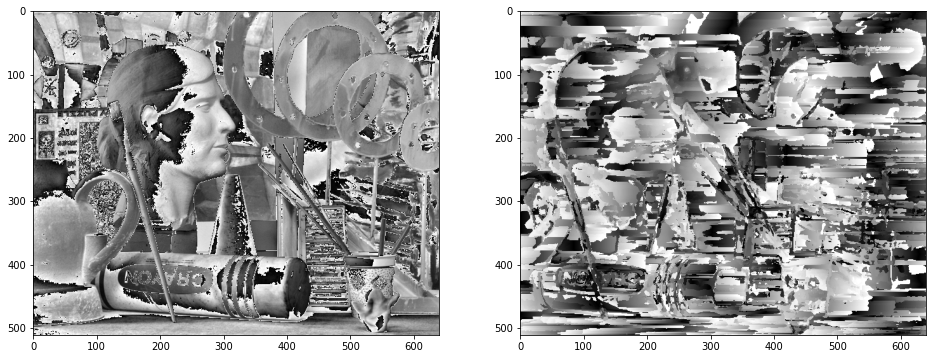

In [ ]:
#Contrast part


contrast_factor = 3
R_contrast = R*contrast_factor
result = stereo_match(L, R_contrast, 6, 250)
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(R_contrast, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')

**Question:** Why is SSD sensitive to Gaussian noise? Why is it sensitive  to changes in contrast?  
**Answer**: SSD is sensitive to gaussian noise because it "masks" the most of the picture, meaning that now with the noise in place, the measured distance between 2 pixels in 2 "picture windows" is more likely to get false results, because now the minimum distance is less likely to be the same as the one that would be measured withput the noise.

Regarding the contrast, the sensitivity is originated in the fact that only one picture is "contrasted", thus bringing a large amount of pixels to "saturation", turning bright pixels dark, and vice versa. This phenomena makes it nearly impossible for the SSD to find the matching pixel in the other image.  


---

### Question 3: Implementing Normalized Cross Correlation (NCC) for Computing Disparity Map

We have now seen that the SSD metric is not robust to small changes between the input images. Therefore, in this section we will compute the correspondences using the Normalized Cross Correlation (NCC) metric introduced in class. 

Repeat Questions 1 and 2 where now, NCC is used for computing the similarity between two window patches. As before, you may use `cv2.matchTemplate` for computing the similarity.

Again, explore different values for the window size and maximum disparity.

Think to yourself: how did the NCC measure affect the results when adding Gaussian noise? How about when changing the contrast? Do your results make sense?

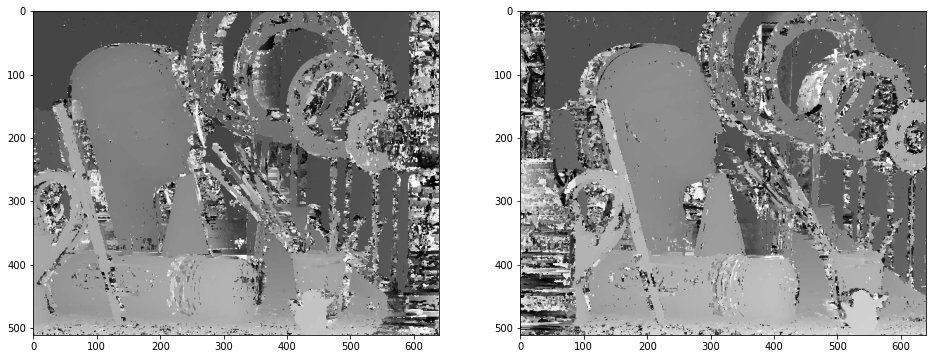

In [ ]:
# Repeat Questions 1 and 2 using the NCC metric for computing similarities
####################
## YOUR CODE HERE 
####################

#Repeat question 1

left = cv2.pyrDown(L)
right = cv2.pyrDown(R)
left_to_right = stereo_match(L, R, 6, 250, cv2.TM_CCORR_NORMED)
right_to_left = stereo_match(R, L, 6, 250, cv2.TM_CCORR_NORMED)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(left_to_right, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(right_to_left, cmap='gray')


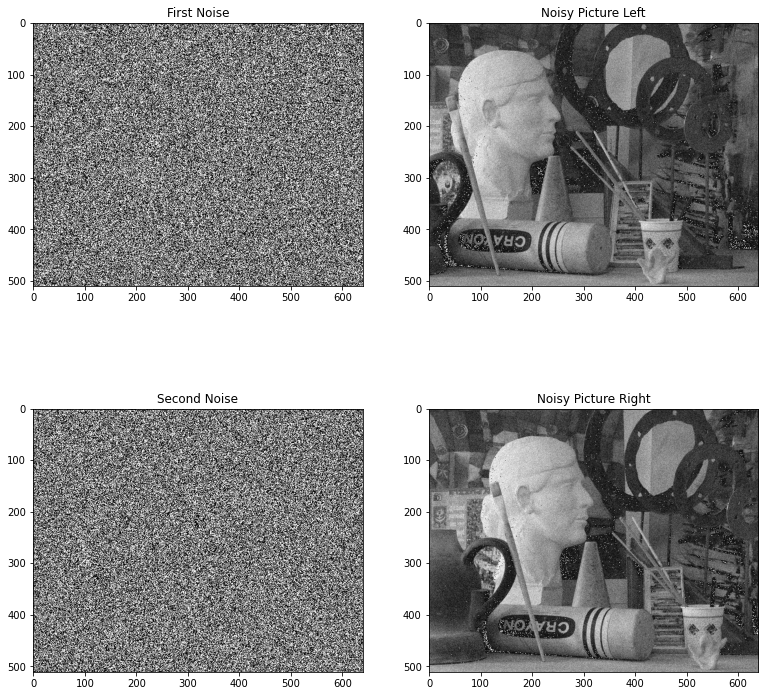

In [ ]:
#Repeat question 2

noise1 = np.uint8(np.random.normal(0,15, L.shape))
noise_left = noise1 + L

noise2 = np.uint8(np.random.normal(0,15, R_org.shape))
noise_right = noise2 + R

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(noise1, cmap='gray')
ax[0, 1].imshow(noise_left, cmap='gray')
ax[1, 0].imshow(noise2, cmap='gray')
ax[1, 1].imshow(noise_right, cmap='gray')

ax[0, 0].set_title("First Noise")
ax[0, 1].set_title("Noisy Picture Left")
ax[1, 0].set_title("Second Noise")
ax[1, 1].set_title("Noisy Picture Right")

fig.set_figheight(13)
fig.set_figwidth(13)
plt.show()

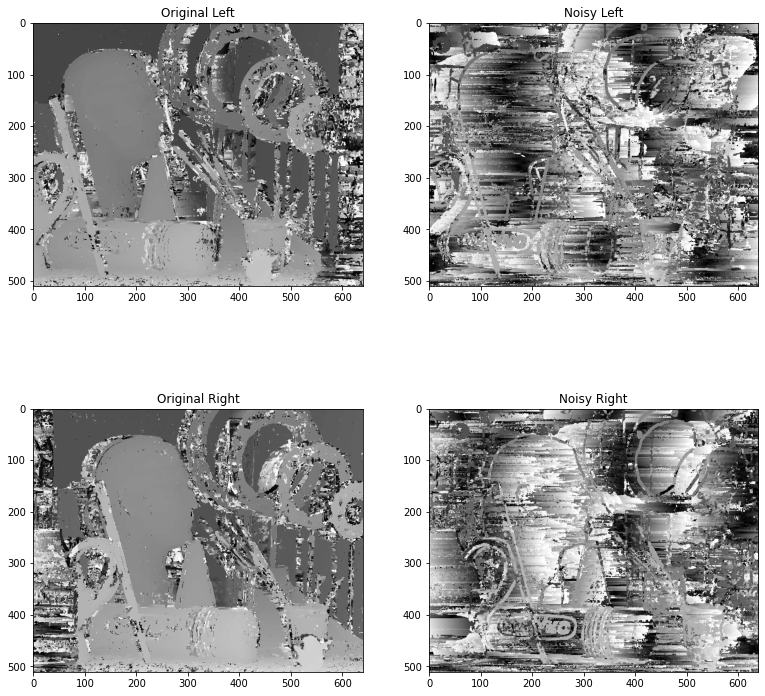

In [ ]:
left_to_right_noise = stereo_match(L, noise_right, 6, 250, cv2.TM_CCORR_NORMED)
right_to_left_noise = stereo_match(R, noise_left, 6, 250, cv2.TM_CCORR_NORMED)

#Comparing pictures
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(left_to_right, cmap='gray')
ax[0, 1].imshow(left_to_right_noise, cmap='gray')
ax[1, 0].imshow(right_to_left, cmap='gray')
ax[1, 1].imshow(right_to_left_noise, cmap='gray')

ax[0, 0].set_title("Original Left")
ax[0, 1].set_title("Noisy Left")
ax[1, 0].set_title("Original Right")
ax[1, 1].set_title("Noisy Right")

fig.set_figheight(13)
fig.set_figwidth(13)
plt.show()